In [3]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import torch
from tqdm import tqdm
import time

In [4]:
class FastMTCNN(object):
    """Fast MTCNN implementation."""
    
    def __init__(self, stride, resize=1, *args, **kwargs):
        """Constructor for FastMTCNN class.
        
        Arguments:
            stride (int): The detection stride. Faces will be detected every `stride` frames
                and remembered for `stride-1` frames.
        
        Keyword arguments:
            resize (float): Fractional frame scaling. [default: {1}]
            *args: Arguments to pass to the MTCNN constructor. See help(MTCNN).
            **kwargs: Keyword arguments to pass to the MTCNN constructor. See help(MTCNN).
        """
        self.stride = stride
        self.resize = resize
        self.mtcnn = MTCNN(*args, **kwargs)
        
    def __call__(self, frames):
        """Detect faces in frames using strided MTCNN."""
        if self.resize != 1:
            frames = [
                cv2.resize(f, (int(f.shape[1] * self.resize), int(f.shape[0] * self.resize)))
                    for f in frames
            ]
                      
        boxes, probs = self.mtcnn.detect(frames[::self.stride])

        faces = []
        for i, frame in enumerate(frames):
            box_ind = int(i / self.stride)
            if boxes[box_ind] is None:
                continue
            for box in boxes[box_ind]:
                box = [int(b) for b in box]
                faces.append(frame[box[1]:box[3], box[0]:box[2]])
        
        return faces

## Extract from Video Feed

In [89]:
vids_path = '../Data/Videos/*.mp4'
vids_path = glob(vids_path)
vids_path

['../Data/Videos/Aman_1.mp4',
 '../Data/Videos/Fahad.mp4',
 '../Data/Videos/Prith.mp4',
 '../Data/Videos/Prith_1.mp4',
 '../Data/Videos/Chris.mp4',
 '../Data/Videos/Aman.mp4',
 '../Data/Videos/Fahad_2.mp4',
 '../Data/Videos/Fahad_3.mp4',
 '../Data/Videos/Fahad_1.mp4',
 '../Data/Videos/Chris_1.mp4']

In [43]:
detector = FastMTCNN(
    stride=4,
    resize=1,
    margin=14,
    factor=0.6,
    keep_all=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [91]:
def run_detection(fast_mtcnn, filenames):
    frames = []
    frames_processed = 0
    faces_detected = 0
    batch_size = 60
    start = time.time()
    
    face_counter = 0
    for filename in tqdm(filenames):
        print(f'File: {filename}')
        name = filename.rsplit('/')[-1].split('.')[0].split('_')[0]

        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        
        for j in range(v_len):
            ret, frame = v_cap.read()
            if not ret: break
                
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

            if len(frames) >= batch_size or j == v_len - 1:
                faces = fast_mtcnn(frames)
                frames_processed += len(frames)
                faces_detected += len(faces)
                frames = []

                print(
                    f'Frames per second: {frames_processed / (time.time() - start):.3f},',
                    f'faces detected: {faces_detected}\r',
                    end='')

                for face in faces:
                    plt.imsave(f'../Data/Faces/{name}_{face_counter}.png', face)
                    face_counter += 1

run_detection(detector, vids_path)

  0%|                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

File: ../Data/Videos/Chris_1.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.98s/it]


## Extract from Photo Feed

In [32]:
pic_paths = glob('../Data/Photos/*.jpg')
pics = [cv2.imread(pic) for pic in pic_paths]

In [31]:
import mtcnn

detector = mtcnn.MTCNN()

def get_face(bbox, orig_im):
    x, y, width, height = bbox[0], bbox[1], bbox[2], bbox[3]
    return orig_im[y:(y+height), x:(x+width)]

In [33]:
extracted_faces = []
for pic in pics:
    faces = detector.detect_faces(pic)
    for face in faces:
        face = get_face(face['box'], pic)
        extracted_faces.append(face)

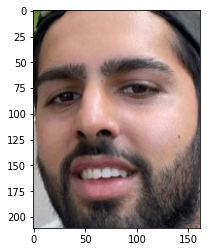

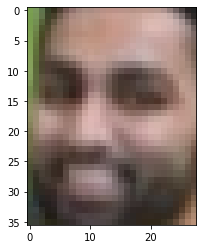

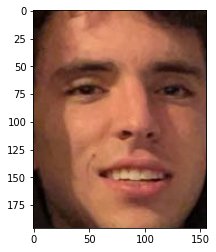

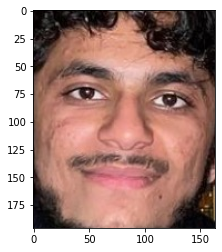

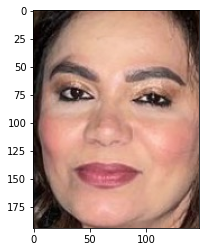

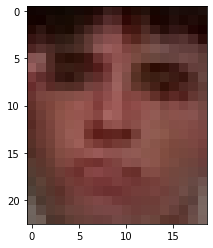

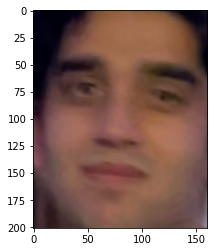

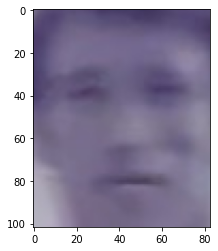

In [38]:
import matplotlib.pyplot as plt

for i, face in enumerate(extracted_faces):
    extracted_faces[i] = cv2.cvtColor(face,cv2.COLOR_RGB2BGR)
    plt.imshow(extracted_faces[i])
    plt.show()

In [39]:
plt.imsave(f'../Data/Faces/aman_11111.png', extracted_faces[0]) 
plt.imsave(f'../Data/Faces/chris_11111.png', extracted_faces[2])
plt.imsave(f'../Data/Faces/fahad_11111.png', extracted_faces[3]) 
plt.imsave(f'../Data/Faces/prith_11111.png', extracted_faces[6]) 